In [2]:
import numpy as np  
import matplotlib.pylab as plt
import pickle
from sklearn.decomposition import PCA
import gpflow

In [1]:
def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)


def modelLoad(nRankMax, snap_ID):
    GPmodel = modelDir + 'noARDGP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
    PCAmodel = modelDir + 'noARDPCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    GPm = saver.load(GPmodel, context=ctx_for_loading)
    GPm.clear()
    GPm.compile()
    PCAm = pickle.load(open(PCAmodel, 'rb'))

    print(GPmodel)
    return GPm, PCAm

def GPy_predict(gpmodel, para_array):
    m1p = gpmodel.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(gpmodel, pcamodel, para_array):
    para_array = np.array(para_array)
    print(para_array)
    para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
    if len(para_array.shape) == 1:
        print(para_array_rescaled)
        W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pcamodel.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def MGemu(Om, ns, s8, fR0, n, z):
    if (z==0):
        GPm, PCAm = modelLoad(nRankMax, 99)
        Pk_interp = Emu(GPm, PCAm, [Om, ns, s8, fR0, n])

    else:
        snap_idx_nearest = (np.abs(z_all - z)).argmin()
        if (z > z_all[snap_idx_nearest]): 
            snap_ID_z1 = snap_idx_nearest - 1    
        else:
            snap_ID_z1 = snap_idx_nearest 
        snap_ID_z2 = snap_ID_z1 + 1

        GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
        Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
        z1 = z_all[snap_ID_z1]

        GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
        Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
        z2 = z_all[snap_ID_z2]
        
        # print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
        print('Linear interpolating for snapshots ', 'for z1= '+ str(snap_ID_z1), 'and z2= '+ str(snap_ID_z2))
        
        Pk_interp = np.zeros_like(Pk_z1)
        Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp


In [3]:
nRankMax = 16
# del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 


dataDir = "./Data/Emulator213bins/" ## Data folder
modelDir = "./Models/" ## Data folder

az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbins_' + str(99) + '.txt'

loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
z_all = az[:, 1]

lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims.txt')

In [4]:
nbody_1 = np.loadtxt('./Data/Nbody_validation/ratios_19.txt')
nbody_2 = np.loadtxt('./Data/Nbody_validation/ratios_22.txt')
nbody_3 = np.loadtxt('./Data/Nbody_validation/ratios_27.txt')
nbody_4 = np.loadtxt('./Data/Nbody_validation/ratios_29.txt')
nbody_5 = np.loadtxt('./Data/Nbody_validation/ratios_33.txt')
nbody_6 = np.loadtxt('./Data/Nbody_validation/ratios_35.txt')
nbody_7 = np.loadtxt('./Data/Nbody_validation/ratios_36.txt')
nbody_8 = np.loadtxt('./Data/Nbody_validation/ratios_38.txt')

nbody_pk = np.array([nbody_1, nbody_2, nbody_3, nbody_4, nbody_5, nbody_6, nbody_7, nbody_8])


In [6]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
n_f=1

fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6

z_array = [1.016539373193011, 0.806909104243328, 0.505668030951772, 0.398366114391517, 0.200981514826109, 0.109319263502801, 0.064946498060623, 0.0]

In [5]:
snap_id_array = [0, 3, 5, 7] #range(8)








./Models/noARDGP_smooth_rank16snap47
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25      ]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
./Models/noARDGP_smooth_rank16snap48
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25      ]
Linear interpolating for snapshots  for z1= 47 and z2= 48
./Models/noARDGP_smooth_rank16snap69
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25    

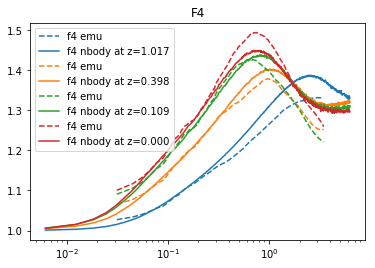

In [7]:
plt.figure(1)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='f4 emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 1], label='f4 nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F4')
plt.legend()
plt.show()

./Models/noARDGP_smooth_rank16snap47
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
./Models/noARDGP_smooth_rank16snap48
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
Linear interpolating for snapshots  for z1= 47 and z2= 48
./Models/noARDGP_smooth_rank16snap69
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
./Models/noARDGP_smooth_rank16snap70
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
Linear interpolating for snapshots  for z1= 69 and z2= 70
./Models/noARDGP_smooth_rank16snap88
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
./Models/noARDGP_smooth_

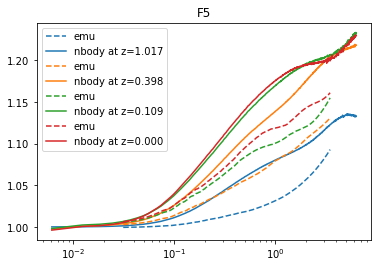

In [8]:
plt.figure(2)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 2], label='nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F5')
plt.legend()
plt.show()

./Models/noARDGP_smooth_rank16snap47
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-06
 1.00000000e+00]
[0.47178083 0.605      0.6        0.00990099 0.25      ]
./Models/noARDGP_smooth_rank16snap48
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-06
 1.00000000e+00]
[0.47178083 0.605      0.6        0.00990099 0.25      ]
Linear interpolating for snapshots  for z1= 47 and z2= 48
./Models/noARDGP_smooth_rank16snap69
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-06
 1.00000000e+00]
[0.47178083 0.605      0.6        0.00990099 0.25      ]
./Models/noARDGP_smooth_rank16snap70
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-06
 1.00000000e+00]
[0.47178083 0.605      0.6        0.00990099 0.25      ]
Linear interpolating for snapshots  for z1= 69 and z2= 70
./Models/noARDGP_smooth_rank16snap88
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-06
 1.00000000e+00]
[0.47178083 0.605      0.6        0.00990099 0.25      ]
./Models/noARDGP_smooth_

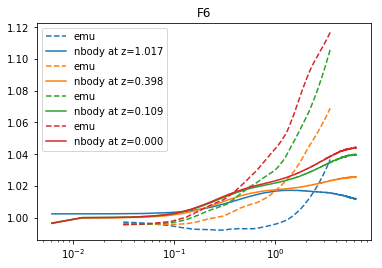

In [10]:
plt.figure(3)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 3], label='nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F6')
plt.legend()
plt.show()

In [9]:
# GPmodel, PCAmodel = modelLoad(nRankMax, 47)
# print(Emu(GPmodel, PCAmodel, np.array([Om_f, ns_f, s8_f, fr0_f6, n_f])))

def modelLoad102(nRankMax, snap_ID):
    GPmodel = modelDir + '102GP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
    PCAmodel = modelDir + '102PCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    GPm = saver.load(GPmodel, context=ctx_for_loading)
    GPm.clear()
    GPm.compile()
    PCAm = pickle.load(open(PCAmodel, 'rb'))

    print(GPmodel)
    return GPm, PCAm

GPmodel, PCAmodel = modelLoad102(nRankMax, 47)
print(Emu(GPmodel, PCAmodel, np.array([Om_f, ns_f, s8_f, fr0_f6, n_f])))
print([Om_f, ns_f, s8_f, fr0_f6, n_f])

./Models/102GP_smooth_rank16snap47
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-06
 1.00000000e+00]
[0.47178083 0.605      0.6        0.00990099 0.25      ]
[1.00036265 1.00031544 1.00026357 1.00020723 1.00014657 1.00008178
 1.00001303 0.99994049 0.99986433 0.99978473 0.99970186 0.9996159
 0.99952701 0.99943537 0.99934115 0.99924452 0.99914567 0.99904476
 0.99894196 0.99883745 0.9987314  0.99862398 0.99851538 0.99840575
 0.99829527 0.99818412 0.99807342 0.99795304 0.99781982 0.9977178
 0.99762024 0.99750662 0.99739835 0.99725355 0.99713478 0.99703017
 0.99694146 0.99684531 0.99677346 0.99668003 0.99660194 0.99653374
 0.99643168 0.9963569  0.99627254 0.99618255 0.99610111 0.99603862
 0.9959486  0.9958464  0.99575989 0.99566101 0.99558082 0.99550137
 0.9953645  0.99529007 0.99521871 0.99513007 0.99502455 0.99490582
 0.9947697  0.99463888 0.99453279 0.99453198 0.99446673 0.99438997
 0.99426225 0.99419533 0.99412574 0.99405121 0.99397895 0.99389487
 0.99381197 0.99374959 0.993